In this notebook, we use CLIP model to generate image embeddings and store them in an OpenSearch index. Then we perform search (like we did in the [previous notebook](03_search_and_eval.ipynb) and perform evaluation using a judgement dataset.

### Prepare OpenSearch

In [5]:
from opensearchpy import OpenSearch

client = OpenSearch("http://localhost:9200")

In [6]:
index_name = 'images'

index_body = {
  'settings': {
    'index': {
      "knn": True
    }
  },
  "mappings": {
            "properties": {
                "embedding": {
                    "type": "knn_vector",
                    "dimension": 512
                }
            }
        }
}

In [7]:
client.indices.create(index_name, body=index_body)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'images'}

### Generate Image Embeddings

In [8]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import requests
from io import BytesIO

In [11]:
import pandas as pd

df = pd.read_csv('../data/vgenome_sample_1k.csv', index_col=0)
df.shape

(1000, 3)

In [12]:
df.head(2)

,image_id,image_url,tags
53559,2366867,http://crowdfile.blob.core.chinacloudapi.cn/46...,"['birds', 'camera', 'bird', 'sky', 'neck', 'pe..."
41981,2378980,http://crowdfile.blob.core.chinacloudapi.cn/46...,"['window', 'line', 'double door', 'front winds..."


In [9]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_image_embedding_from_url(url):
    """
    Reads the raw image from the URL and returns image embeddings using CLIP model.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Failed to download image. Status code: {response.status_code}")
    
    image = Image.open(BytesIO(response.content)).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    return image_features

#### test a single URL

In [13]:
image_url = list(df['image_url'])[0]
image_url

'http://crowdfile.blob.core.chinacloudapi.cn/4615/2366867.jpg'

In [16]:
image_url = list(df['image_url'])[100]
image_url

'http://crowdfile.blob.core.chinacloudapi.cn/4615/2407115.jpg'

In [14]:
embedding = get_image_embedding_from_url(image_url)

print("Image Embedding:", embedding)
print("Embedding Shape:", embedding.shape)

ConnectionError: HTTPConnectionPool(host='crowdfile.blob.core.chinacloudapi.cn', port=80): Max retries exceeded with url: /4615/2366867.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f31e60dc790>: Failed to establish a new connection: [Errno -2] Name or service not known'))

Unfortunately, this didn't work because the URLs provided are not valid. We need to figure out if there's a valid URL from where we can pull these images. We can always download them directly, but that's to much unnecessary data (more than 14 GB).

HuggingFace's datasets library has this data. Based on the description on that [dataset's page](https://huggingface.co/datasets/ranjaykrishna/visual_genome), it looks like stanform.edu has this data hosted. One example link from this page looks like this: `https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg`. Let's see if this works. The biggest issue here that we need to confirm is if the image ID, i.e., `filename.jpg`, are consistend between the two datasets.

In [23]:
image_url = list(df['image_url'])[100]
image_url = image_url.replace('http://crowdfile.blob.core.chinacloudapi.cn/4615', 'https://cs.stanford.edu/people/rak248/VG_100K_2')
image_url

'https://cs.stanford.edu/people/rak248/VG_100K_2/2407115.jpg'

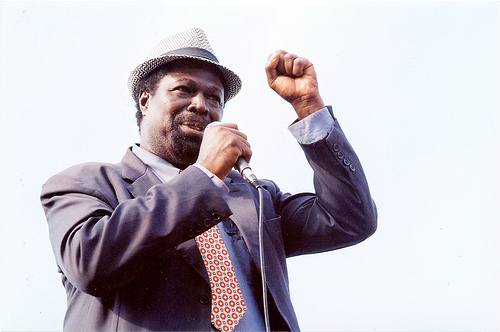

In [25]:
from IPython.display import Image, display

response = requests.get(image_url)

if response.status_code == 200:
    display(Image(response.content))
else:
    print("Failed to fetch image:", response.status_code)

Let's check what tags we have for this image ID.

In [30]:
from pathlib import Path

Path(image_url).stem

'2407115'

In [32]:
df.dtypes

image_id      int64
image_url    object
tags         object
dtype: object

In [35]:
df[df['image_id'] == int(Path(image_url).stem)]['tags'].values

array(["['cuff', 'wire', 'mouth', 'man', 'collar', 'tie', 'coat', 'button', 'shirt', 'hair', 'background', 'hand', 'nose', 'teeth', 'hat', 'microphone', 'circle', 'elbow', 'band', 'lapel', 'facial hair']"],
      dtype=object)

Okay, that looks good. So now all we need to do is edit the URLs on the fly and then generate embeddings.

In [46]:
def get_image_embedding_from_url(url):
    """
    Updated to change the URL to stanford
    """
    url = url.replace('http://crowdfile.blob.core.chinacloudapi.cn/4615', 'https://cs.stanford.edu/people/rak248/VG_100K_2')
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to download image. Status code: {response.status_code}. Image ID: {Path(url).stem}")
        return []
    else:
        image = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        return image_features

In [39]:
from PIL import Image

original_url = image_url = list(df['image_url'])[100]

embedding = get_image_embedding_from_url(original_url)

print("Image Embedding:", embedding)
print("Embedding Shape:", embedding.shape)

Image Embedding: tensor([[-3.0047e-02,  1.3798e-02,  2.0608e-02, -2.5926e-02,  1.6204e-02,
          4.6121e-02, -3.6586e-02,  5.9838e-03,  8.9791e-03,  3.4367e-02,
          3.0029e-02,  1.7072e-02, -5.7102e-02,  1.9126e-02,  1.5771e-02,
          3.6129e-02,  1.5801e-01,  8.6084e-03, -1.9979e-02,  3.1234e-02,
         -1.0953e-02, -2.7018e-02, -6.5434e-03, -2.4393e-02, -1.9755e-02,
          2.0430e-02,  2.5274e-02, -2.0320e-02, -1.6332e-02,  2.4468e-02,
         -1.4333e-02,  5.2850e-02, -3.5859e-02,  2.4707e-02,  3.2052e-02,
          4.3431e-02, -1.5107e-02,  7.7918e-03,  1.5209e-02,  1.4911e-01,
          2.2131e-04, -9.5154e-02, -3.0854e-02,  9.4707e-03, -2.3313e-02,
          1.8240e-01,  6.0893e-02,  2.8236e-02, -2.0942e-02, -5.9689e-02,
          3.8609e-02,  1.8954e-02, -2.9296e-02,  1.1618e-02, -3.3098e-02,
          2.1017e-02,  6.1695e-02,  1.3522e-02,  1.2031e-02,  2.5768e-02,
          3.6889e-03, -1.5207e-02, -3.0718e-02,  5.2270e-02, -6.1428e-03,
         -2.8086e-02,

Okay, that worked! Now let's hope that this works for all 1,000 images.

In [50]:
all_embeddings = []

for i, row in df.iterrows():
    
    original_url = row['image_url']
    
    embedding = get_image_embedding_from_url(original_url)

    all_embeddings.append(embedding)

Failed to download image. Status code: 404. Image ID: 2366867
Failed to download image. Status code: 404. Image ID: 2329504
Failed to download image. Status code: 404. Image ID: 2347788
Failed to download image. Status code: 404. Image ID: 2318253
Failed to download image. Status code: 404. Image ID: 2325505
Failed to download image. Status code: 404. Image ID: 2375554
Failed to download image. Status code: 404. Image ID: 2338858
Failed to download image. Status code: 404. Image ID: 285966
Failed to download image. Status code: 404. Image ID: 2333971
Failed to download image. Status code: 404. Image ID: 2318141
Failed to download image. Status code: 404. Image ID: 2370306
Failed to download image. Status code: 404. Image ID: 107926
Failed to download image. Status code: 404. Image ID: 2325122
Failed to download image. Status code: 404. Image ID: 2348450
Failed to download image. Status code: 404. Image ID: 2362686
Failed to download image. Status code: 404. Image ID: 2321096
Failed to 

A lot of images were missed. I guess they might be stored in a different directory..?

In [58]:
sum(len(x) if x is not [] else 0 for x in all_embeddings)

410

Only 410 images are found -- that's okay, we will work with that.

In [67]:
df['image_embedding'] = [embedding for embedding in all_embeddings]

df.shape

(1000, 5)

In [69]:
df = df[df['image_embedding'].apply(lambda x: x != [])]
df.shape

(410, 5)

In [71]:
df = df.drop(columns=['image_url', 'embedding'])

Convert the tensors into a list.

In [72]:
df['image_embedding'] = df['image_embedding'].apply(lambda x: x.tolist())
df.head()

,image_id,tags,image_embedding
41981,2378980,"['window', 'line', 'double door', 'front winds...","[[-0.004452705383300781, 0.010793974623084068,..."
107821,2417733,"['sand', 'left arm', 'head', 'kite', 'sky', 's...","[[0.006527651101350784, 0.017943937331438065, ..."
23392,2398437,"['horse', 'head', 'leg', 'mouth', 'neck', 'hay...","[[-0.037737887352705, -0.008829250000417233, -..."
14033,2408241,"['grass', 'line', 'bike', 'man', 'motorcycle',...","[[0.023501038551330566, 0.04544584080576897, -..."
831,832,"['powerline', 'mirror', 'sky', 'wall', 'electr...","[[-0.013713749125599861, 0.047814175486564636,..."


It's still a list of list, UGH!

In [76]:
df['image_embedding'] = df['image_embedding'].apply(lambda x: x[0])
df.head()

,image_id,tags,image_embedding
41981,2378980,"['window', 'line', 'double door', 'front winds...","[-0.004452705383300781, 0.010793974623084068, ..."
107821,2417733,"['sand', 'left arm', 'head', 'kite', 'sky', 's...","[0.006527651101350784, 0.017943937331438065, -..."
23392,2398437,"['horse', 'head', 'leg', 'mouth', 'neck', 'hay...","[-0.037737887352705, -0.008829250000417233, -0..."
14033,2408241,"['grass', 'line', 'bike', 'man', 'motorcycle',...","[0.023501038551330566, 0.04544584080576897, -0..."
831,832,"['powerline', 'mirror', 'sky', 'wall', 'electr...","[-0.013713749125599861, 0.047814175486564636, ..."


### Ingest embeddings into OpenSearch

In [77]:
payload = []

for i, row in df.iterrows():
    action = {
            "_index": "images",
            "_source": {
                "image_id": row['image_id'],
                "embedding": row['image_embedding']
        }
    }
    payload.append(action)

In [78]:
from opensearchpy.helpers import bulk

success, _ = bulk(client, payload, index="images")

In [80]:
success

410

Great, we have indexed all images!

### Perform vector search

We need a function that will take the search string and convert it into text embedding using the same model that we used to generate embeddings from images.

In [81]:
def get_text_embedding(search_string):
    inputs = processor(text=search_string, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    return text_features

# example
search_string = "A cute cat"
embedding = get_text_embedding(search_string)

print("Text Embedding:", embedding)
print("Embedding Shape:", embedding.shape)

Text Embedding: tensor([[ 7.2488e-03, -1.7793e-02, -2.1957e-02, -2.8312e-02, -1.9938e-02,
          1.9974e-02, -3.2781e-02, -7.8182e-02, -2.5262e-02, -1.0236e-03,
          5.3226e-03, -4.4380e-02,  2.0956e-02, -2.0570e-02,  7.2128e-03,
          3.5790e-02,  3.2468e-02, -2.1906e-02, -1.3014e-02,  3.4516e-02,
          4.3194e-02,  1.7080e-02,  3.5280e-02, -9.9673e-04, -2.2055e-02,
          2.2700e-03,  1.7560e-02,  3.9876e-02, -3.2348e-03, -1.5271e-02,
          1.0379e-02, -7.5354e-03,  2.1494e-02,  3.7524e-02, -9.2431e-03,
         -6.6733e-03,  1.3023e-02,  2.2631e-02,  2.0402e-02,  1.8866e-02,
         -1.0741e-02,  5.2984e-03,  1.3958e-02,  1.0697e-02, -5.5452e-03,
          2.8825e-02, -1.5623e-02, -2.1491e-02, -1.4125e-02, -1.4949e-02,
          9.8928e-03, -2.9202e-03,  2.5782e-02, -1.0936e-02,  4.3213e-03,
         -2.5580e-02, -2.8034e-03,  2.2280e-02, -2.5653e-03, -1.6464e-02,
          5.0255e-02,  7.8281e-04, -2.5887e-02, -9.7113e-03, -1.0742e-03,
         -2.7273e-02, 

In [97]:
import numpy as np

def search_images(search_phrase, k=10, index_name='images'):
    """
    Perform a k-nearest neighbor search on the specified OpenSearch index.
    """
    try:
        vector = get_text_embedding(search_phrase)
        
        if not isinstance(vector, (list, torch.Tensor, np.ndarray)):
            raise ValueError("Invalid embedding format. Expected a list, numpy array, or PyTorch tensor.")
        
        if isinstance(vector, (torch.Tensor, np.ndarray)):
            vector = vector.tolist()

        payload = {
            "query": {
                "knn": {
                    "embedding": {
                        "vector": vector[0],
                        "k": k
                    }
                }
            }
        }

        # perform search
        result = client.search(index=index_name, body=payload)
        
        return result
    
    except ValueError as ve:
        print(f"ValueError: {ve}")
        return None
    
    except Exception as e:
        print(f"An error occurred during the search: {e}")
        return None

In [106]:
search_phrase = 'musical instrument'

results = search_images(search_phrase)

matched_images_w_scores = [(results_dict['_source']['image_id'], 
                            results_dict['_score']) for results_dict in results['hits']['hits']]

In [107]:
matched_images, scores = zip(*matched_images_w_scores)
matched_images, scores

((2416635,
  2400373,
  2378976,
  2400494,
  2384613,
  4404,
  2399847,
  2222,
  2407894,
  2404968),
 (0.40369633,
  0.39639255,
  0.3962626,
  0.39615494,
  0.3950924,
  0.394273,
  0.39415208,
  0.3928177,
  0.39259863,
  0.39243665))

### Evals

First, we need to create a judgment dataset.

In [108]:
df.head()

,image_id,tags,image_embedding
41981,2378980,"['window', 'line', 'double door', 'front winds...","[-0.004452705383300781, 0.010793974623084068, ..."
107821,2417733,"['sand', 'left arm', 'head', 'kite', 'sky', 's...","[0.006527651101350784, 0.017943937331438065, -..."
23392,2398437,"['horse', 'head', 'leg', 'mouth', 'neck', 'hay...","[-0.037737887352705, -0.008829250000417233, -0..."
14033,2408241,"['grass', 'line', 'bike', 'man', 'motorcycle',...","[0.023501038551330566, 0.04544584080576897, -0..."
831,832,"['powerline', 'mirror', 'sky', 'wall', 'electr...","[-0.013713749125599861, 0.047814175486564636, ..."


#### Top 10 tags

In [115]:
import ast

# convert the `tags` column into a list
df['tags'] = df['tags'].apply(ast.literal_eval)

In [118]:
from collections import Counter

# get the list of all tags
all_tags = []

for tag in df['tags'].values:
    all_tags += tag

# count the number of occurrences (images) for each tag
occurrences = pd.Series(all_tags).value_counts()
select_tags = list(occurrences[:10].index.values)
select_tags

['man',
 'tree',
 'wall',
 'shirt',
 'sky',
 'building',
 'window',
 'grass',
 'ground',
 'head']

In addition, take five random tags.

In [119]:
import random

random_tags = random.sample(all_tags, 5)
random_tags

['spectacles', 'bananas', 'girl', 'sand', 'sink']

In [120]:
# append the five random tags to the original list
select_tags = list(set(select_tags + random_tags))

#### Add ground truth

In [122]:
judgement_data = {}

for search_tag in select_tags:
    matched_images = []
    # for each select tag, iterate thru the dataset
    for i, row in df.iterrows():
        # for each row (image) in the dataset, add the image if that tag was found in that image
        for available_tag in set(row['tags']):
            if available_tag == search_tag:
                matched_images.append(row['image_id'])
    judgement_data[search_tag] = matched_images

# convert the dictionary into a dataframe
df_judgement = pd.DataFrame(list(judgement_data.items()),
                            columns=['search_tag', 'image_ids'])

df_judgement['matched_image_ct'] = df_judgement['image_ids'].apply(lambda x: len(x))

df_judgement.head()

,search_tag,image_ids,matched_image_ct
0,man,"[2417733, 2408241, 2403729, 2396856, 2405849, ...",105
1,sink,"[508, 2411378, 2394652, 2416381, 2403373]",5
2,tree,"[2378980, 2398437, 832, 2405367, 2378215, 2110...",92
3,wall,"[832, 512, 2399605, 2377478, 2390176, 4404, 24...",89
4,shirt,"[2417733, 2399152, 2396856, 2405849, 4689, 239...",89


#### Perform search

In [123]:
def find_matched_images(search_phrase):    
    """
    For a given search phrase, performs search and returns matched images and scores
    """
    results = search_images(search_phrase)
    matched_images_w_scores = [(results_dict['_source']['image_id'], 
                                results_dict['_score']) for results_dict in results['hits']['hits']]
    matched_images, scores = zip(*matched_images_w_scores)
    return matched_images, scores

In [125]:
for i, row in df_judgement.iterrows():
 
    matched_images, scores = find_matched_images(row['search_tag'])

    # update the judgement dataset
    df_judgement.loc[i, 'search_results'] = str(matched_images)

/tmp/ipykernel_2666/350506008.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(2222, 3688, 2411378, 2402423, 2399290, 2388317, 2397029, 2409188, 2380474, 2395384)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_judgement.loc[i, 'search_results'] = str(matched_images)


In [126]:
df_judgement.head()

,search_tag,image_ids,matched_image_ct,search_results
0,man,"[2417733, 2408241, 2403729, 2396856, 2405849, ...",105,"(2222, 3688, 2411378, 2402423, 2399290, 238831..."
1,sink,"[508, 2411378, 2394652, 2416381, 2403373]",5,"(508, 2411378, 2394195, 2403373, 2405849, 2407..."
2,tree,"[2378980, 2398437, 832, 2405367, 2378215, 2110...",92,"(4441, 2395569, 832, 2416525, 2399847, 2392976..."
3,wall,"[832, 512, 2399605, 2377478, 2390176, 4404, 24...",89,"(4441, 2397146, 2411378, 2400808, 2395968, 239..."
4,shirt,"[2417733, 2399152, 2396856, 2405849, 4689, 239...",89,"(2402423, 2396603, 2392144, 3688, 4404, 239929..."


In [127]:
df_judgement["search_results"] = df_judgement["search_results"].apply(
    lambda x: list(map(int, ast.literal_eval(x))))

#### Precision and recall

In [128]:
df_judgement["common_count"] = df_judgement.apply(
    lambda row: len(set(row["image_ids"]) & set(row["search_results"])), axis=1)

In [131]:
# precision: how many of the matched images are actually correct?
df_judgement['precision'] = df_judgement['common_count'] / 10

# recall: how many of the correct images are captured by search
df_judgement[f'recall_at_{10}'] = df_judgement['common_count'] / df_judgement['matched_image_ct'] 

df_judgement.head()

,search_tag,image_ids,matched_image_ct,search_results,common_count,precision,recall_at_10
0,man,"[2417733, 2408241, 2403729, 2396856, 2405849, ...",105,"[2222, 3688, 2411378, 2402423, 2399290, 238831...",4,0.4,0.038095
1,sink,"[508, 2411378, 2394652, 2416381, 2403373]",5,"[508, 2411378, 2394195, 2403373, 2405849, 2407...",3,0.3,0.600000
2,tree,"[2378980, 2398437, 832, 2405367, 2378215, 2110...",92,"[4441, 2395569, 832, 2416525, 2399847, 2392976...",7,0.7,0.076087
3,wall,"[832, 512, 2399605, 2377478, 2390176, 4404, 24...",89,"[4441, 2397146, 2411378, 2400808, 2395968, 239...",3,0.3,0.033708
4,shirt,"[2417733, 2399152, 2396856, 2405849, 4689, 239...",89,"[2402423, 2396603, 2392144, 3688, 4404, 239929...",4,0.4,0.044944


In [132]:
print(f"Average Precision: {df_judgement['precision'].mean():.2f}")

print(f"Average Recall (at 10): {df_judgement['recall_at_10'].mean():.2f}")

Average Precision: 0.44
Average Recall (at 10): 0.17


These results don't look very impressive, but that's not the point of this notebook. If you are trying different models, quantization techniques, etc. you can calculate the average precision and recall for all those approached and compare them against each other.

### Dashboard

In [133]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, Output, VBox

In [135]:
def fetch_image(image_id):
    url = f"https://cs.stanford.edu/people/rak248/VG_100K_2/{image_id}.jpg"
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        return None

def display_images(search_tag):
    output.clear_output(wait=True)
    image_ids = df_judgement[df_judgement["search_tag"] == search_tag]["image_ids"].values[0]
    fig, axes = plt.subplots(1, 10, figsize=(20, 5))
    
    for ax, image_id in zip(axes, image_ids):
        image = fetch_image(image_id)
        if image:
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(image_id, fontsize=8)
        else:
            ax.set_axis_off()
    
    plt.show()

search_tag_dropdown = Dropdown(
    options=df_judgement["search_tag"].unique(),
    description="Search Tag:",
)

output = Output()

def on_change(change):
    with output:
        display_images(change.new)

search_tag_dropdown.observe(lambda change: on_change(change), names="value")

In [136]:
dashboard = VBox([search_tag_dropdown, output])
display(dashboard)